In [1]:
# Import Libraries
from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score

In [2]:
# Load the data
data = pd.read_csv('./data/bank-full.csv', sep=';')
print(data.shape)
data.head(2)

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [3]:
# Select only the features that are relevant for the analysis
df = data.copy()
df = df[['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month',
        'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]

# Encode the target variable y
df.y = (df.y == 'yes').astype(int)

# Split df into train/val/test sets with 60%/20%/20% ratio
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset the index for all dataframes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print('Train shape:', df_train.shape)
print('Validation shape:', df_val.shape)
print('Test shape:', df_test.shape)

# Separate the target variable from the features
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']


Train shape: (27126, 15)
Validation shape: (9042, 15)
Test shape: (9043, 15)


In [4]:
# Question 1: ROC AUC feature importance
# Which numerical variable (among the following 4) has the highest AUC?

# Define the function to calculate the AUC score
def auc_score(df, feature):
    y_pred = df[feature].values
    auc_score = roc_auc_score(y_train, y_pred)
    return auc_score

# Calculate the AUC score for each numerical feature
numerical_features = ['balance', 'day', 'duration', 'previous']
auc_scores = {}
for feature in numerical_features:
    auc = auc_score(df_train, feature)
    auc_scores[feature] = auc

pprint(auc_scores)


{'balance': np.float64(0.5888313805382317),
 'day': np.float64(0.474042117616092),
 'duration': np.float64(0.8147002759670778),
 'previous': np.float64(0.5985653242764153)}


In [5]:
# If your AUC is < 0.5, invert this variable by putting "-" in front
numerical_features = ['balance', 'day', 'duration', 'previous']
auc_scores = {}
tmp = df_train.copy()

# Calculate the AUC score for each numerical feature
for feature in numerical_features:
    # Invert the feature if it is 'day'
    if feature == 'day':
        tmp[feature] = -tmp[feature]
    auc = auc_score(tmp, feature)
    auc_scores[feature] = auc

pprint(auc_scores)

{'balance': np.float64(0.5888313805382317),
 'day': np.float64(0.525957882383908),
 'duration': np.float64(0.8147002759670778),
 'previous': np.float64(0.5985653242764153)}


In [6]:
# Question 2: Training the model

# Separte the numerical and categorical features
numerical = df_train.select_dtypes(include='number').columns.tolist()
categorical = df.select_dtypes(include='object').columns.tolist()
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

# Apply one-hot encoding for the categorical features in the training set
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
print(X_train.shape)

# One-hot encoding for the categorical features in the validation set
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
print(X_val.shape)

(27126, 47)
(9042, 47)


In [7]:
# Train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict the probabilities
y_pred = model.predict_proba(X_val)[:, 1]

# What's the AUC of this model on the validation dataset? (round to 3 digits)
auc = roc_auc_score(y_val, y_pred)
print('AUC:', round(auc, 2))

AUC: 0.9


In [8]:
# Question 3: Precision and Recall
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
scores = []
thresholds = np.linspace(0, 1, 101)

# For each threshold, compute precision and recall
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    scores.append((t, precision, recall))


/var/folders/rq/q0gd7qms1wl7v17bxq5xqq240000gn/T/ipykernel_27331/3500756171.py:13: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Text(0.5, 1.0, 'Precision and Recall')

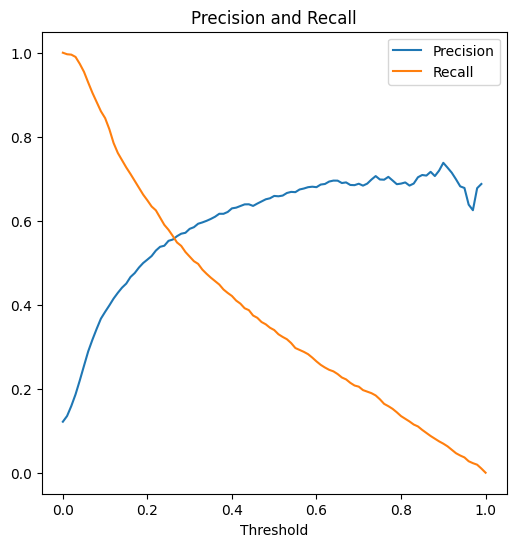

In [9]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

# Plot the precision-recall curve
plt.figure(figsize=(6, 6))
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.legend()
plt.xlabel('Threshold')
plt.title('Precision and Recall')

In [10]:
# At which threshold precision and recall curves intersect?
df_scores[(df_scores.precision - df_scores.recall).abs() < 0.01]

,threshold,precision,recall
26,0.26,0.555157,0.563752


In [11]:
# Question 4: F1 score
# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
scores = []
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

# At which threshold F1 is maximal?
df_scores[df_scores.f1 == df_scores.f1.max()]

,threshold,precision,recall,f1
22,0.22,0.528913,0.624772,0.57286


In [12]:
# Question 5: 5-Fold CV
# Define the function to train the model and get predictions
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [13]:
# Apply 5-Fold CV to evaluate the model
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [14]:
print('fold=%s %.3f +- %.3f' % (range(1,6), np.mean(scores), np.std(scores)))

fold=range(1, 6) 0.906 +- 0.006


In [15]:
# Question 6: Hyperparameter Tuning
# Let's find the best hyperparameter C
# Define the function to train the model and get predictions
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [16]:
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006
